<a href="https://colab.research.google.com/github/apoorvyadav1111/Machine-Learning-Practice/blob/master/Neural_Style_Transfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Original Paper Algo Implementation
- Tutorial: https://www.tensorflow.org/tutorials/generative/style_transfer
- Paper: https://arxiv.org/abs/1508.06576


In [ ]:
import tensorflow as tf
import numpy as np
import time
import matplotlib.pyplot as plt
import matplotlib as mlp
import keras
import PIL.Image as pi
import functools
import IPython.display as display

Using TensorFlow backend.


In [ ]:
def tensor_to_image(tensor):
  tensor = tensor * 255
  tensor = np.array(tensor,dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return pi.fromarray(tensor)

In [ ]:
content_path = "/content/drive/My Drive/Datasets/Style Transfer/minecraft.png"
style_path = "/content/drive/My Drive/Datasets/Style Transfer/land.jpg"

In [ ]:
def read_img(path):
  max_dim = 512
  img = tf.io.read_file(path)
  img = tf.image.decode_image(img,channels = 3)
  img = tf.image.convert_image_dtype(img,dtype=tf.float32)

  shape = tf.cast(tf.shape(img)[:-1],tf.float32)
  long_dim = max(shape)
  scale = max_dim/long_dim
  new_shape = tf.cast(shape*scale,tf.int32)
  re_img = tf.image.resize(img,new_shape)
  re_img = re_img[tf.newaxis, :]
  return re_img

In [ ]:
def imshow(image,title = "Image"):
  if len(image.shape)>3:
    image = tf.squeeze(image,axis = 0)
  plt.imshow(image)
  plt.title(title)

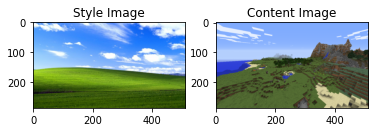

In [ ]:
style_img = read_img(style_path)
content_img = read_img(content_path)
plt.subplot(1,2,1)
imshow(style_img,'Style Image')
plt.subplot(1,2,2)
imshow(content_img,'Content Image')

## Defining Content and Style representations
Loading VGG19 pretrained

In [ ]:
x = tf.keras.applications.vgg19.preprocess_input(content_img*255)
x = tf.image.resize(x,(224,224))
vgg = tf.keras.applications.VGG19(include_top=True,weights='imagenet')
pred = vgg(x)
pred.shape

TensorShape([1, 1000])

In [ ]:
vgg = tf.keras.applications.VGG19(include_top=False,weights='imagenet')
print()
for layer in vgg.layers:
  print(layer.name)


input_2
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [ ]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1'
                ]
n_c_l = len(content_layers)
n_s_l = len(style_layers)


In [ ]:
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False,weights='imagenet')
  vgg.trainable = False
  outputs = [vgg.get_layer(name).output for name in layer_names]
  model = tf.keras.Model([vgg.input],outputs)
  return model

In [ ]:
def gram_matrix(input_tensor):
  res = tf.linalg.einsum('bijc,bijd->bcd',input_tensor,input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2],tf.float32)
  return res/(num_locations)

Extract Style and content

In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output) for style_output in style_outputs]
    content_dict = {content_name:value for content_name, value in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value for style_name, value in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}


In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

In [ ]:
# our ground truth will be run against these.
style_targets = extractor(style_img)['style']
content_targets = extractor(content_img)['content']

In [ ]:
image = tf.Variable(content_img)

In [ ]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [ ]:
def normalize(image):
  return tf.clip_by_value(image,clip_value_min=0,clip_value_max=1)

In [ ]:
def style_content_loss(outputs):
  style_outputs = outputs['style']
  content_outputs = outputs['content']

  style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) for name in style_outputs.keys()])

  style_loss *= style_weight/n_s_l
  
  content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) for name in content_outputs.keys()])

  content_loss *= content_weight/n_c_l

  loss = style_loss + content_loss
  return loss

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
  grad = tape.gradient(loss,image)
  opt.apply_gradients([(grad,image)])
  image.assign(normalize(image))

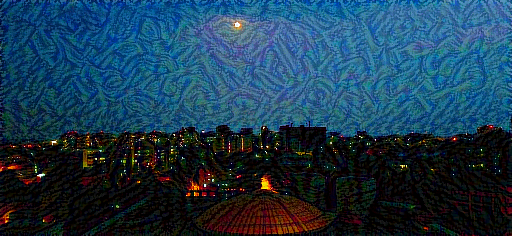

Train step  5
Do You want to continue? Y/N
n


In [ ]:
epochs = 10
steps = 5
step = 0
#providing the importance to things
style_weight = 1e-2
content_weight = 1e3

for n in range(epochs):
  for m in range(steps):
    step += 1
    train_step(image)
    print(".",end='')
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
  print('Train step ',step)
  print('Do You want to continue? Y/N')
  n = input()
  if n == 'N' or n == 'n':
    break

In [ ]:
image.shape

TensorShape([1, 236, 512, 3])

In [ ]:
file_name = 'stylized-image.png'
tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
def high_pass_x_y(image):
  x_var = image[:,:,1:,:] - image[:,:,:-1,:]
  y_var = image[:,1:,:,:] - image[:,:-1,:,:]

  return x_var, y_var

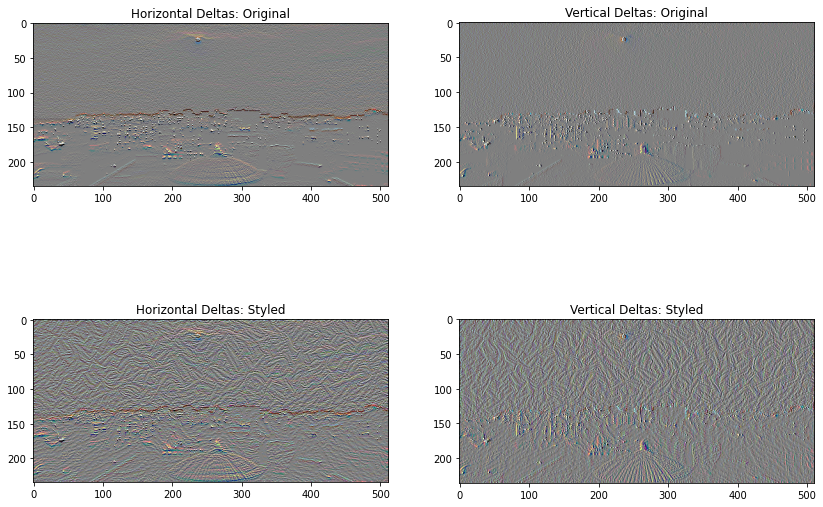

In [ ]:
x_deltas, y_deltas = high_pass_x_y(content_img)

plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
imshow(normalize(2*y_deltas+0.5), "Horizontal Deltas: Original")

plt.subplot(2,2,2)
imshow(normalize(2*x_deltas+0.5), "Vertical Deltas: Original")

x_deltas, y_deltas = high_pass_x_y(image)

plt.subplot(2,2,3)
imshow(normalize(2*y_deltas+0.5), "Horizontal Deltas: Styled")

plt.subplot(2,2,4)
imshow(normalize(2*x_deltas+0.5), "Vertical Deltas: Styled")

In [ ]:
def total_variation_loss(image):
  x_deltas, y_deltas = high_pass_x_y(image)
  return tf.reduce_sum(tf.abs(x_deltas)) + tf.reduce_sum(tf.abs(y_deltas))

In [ ]:
tf.image.total_variation(image).numpy()

array([38566.758], dtype=float32)

In [ ]:
total_variation_loss(image).numpy()

38566.758

## Running the optimized version

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)
  grad = tape.gradient(loss,image)
  opt.apply_gradients([(grad,image)])
  image.assign(normalize(image))

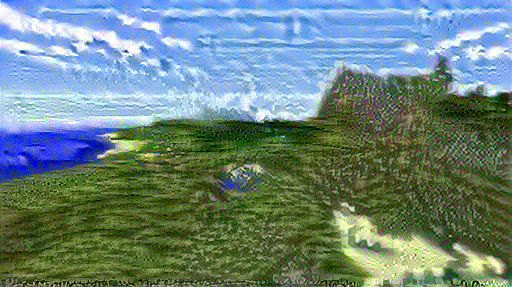

.

In [ ]:
epochs = 100
steps = 50
step = 0
#providing the importance to things
style_weight = 1e-1
content_weight = 1e2
total_variation_weight = 30
for n in range(epochs):
  for m in range(steps):
    step += 1
    print(".",end='')
    train_step(image)
    display.clear_output(wait=True)
    display.display(tensor_to_image(image))
  print("Train Step: ",step)
  print("Do you want to continue Y/N ?")
  n = input()
  if n == 'n' or n=='N':
    break